In [4]:
df <- read.csv("../biostats bootcamp 2023.csv", stringsAsFactors = F)
df$race <- as.factor(df$race)
df$discharge_dispsn <- as.factor(df$discharge_dispsn)

# Exploratory Data Analysis

## Univariate Analysis (Continued)
Last time we started looking at univariate analysis.  As a reminder, for discrete data we discussed:

- Counts / Proportions

For univariate discrete data, proportions are really all you need.  Pie charts really don't give you any extra information and just waste space. For continuous data, we discussed

- Measures of Location (Mean & Median)

- Order Statistics (The Five-Number Summary)

- Histograms

However, for continuous data there are several other useful pieces of information.  Today, we wil discuss:

- Measures of Scale

- Standardization

- Measures of Asymmetry 

- QQ Plots



### Measures of Scale

Another name you might come across is **measures of dispersion**.  Such statistics provide summaries of how far values tend to be away some measure of location.

The most classical measure of scale is the sample **standard deviation**.  It can be calculated simply as follows: 

In [2]:
sd(df$lactate_min)

[1] 0.78435

If we assume the data is unimodal (can check by verifying there is a single hump in the histogram), then the standard deviation can help us determine reasonable intervals of values where we'd expect most of the data to live.  At least 89% of the data will always be within 2 standard deviations from the mean, and at least 95% will be within 3 standard deviations.  Let's visualize this with lactate_min with a window of 2 standard deviations from the min:

[1] "Amount of data in interval: 98.04%"

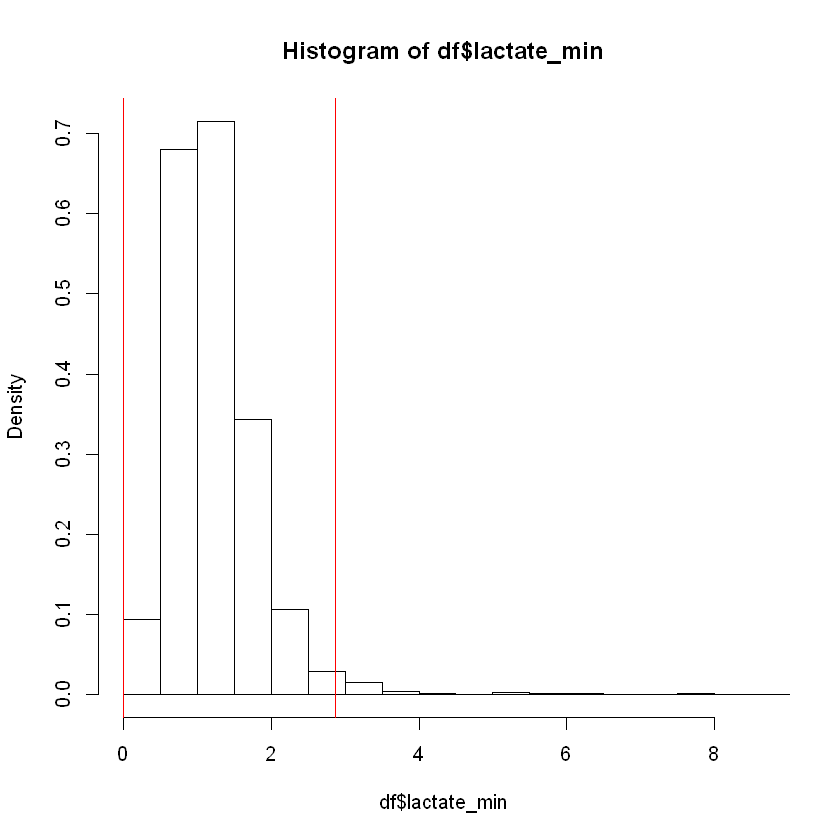

In [3]:
hist(df$lactate_min, probability = T, breaks = 40, xlim = c(0,quantile(df$lactate_min, 0.999)))
left.boundary <- max(0, mean(df$lactate_min) - 2*sd(df$lactate_min))
right.boundary <- mean(df$lactate_min) + 2*sd(df$lactate_min)
abline(v = left.boundary, col = 'red')
abline(v = right.boundary, col = 'red')
paste0("Amount of data in interval: ",
      round(mean(((df$lactate_min >= left.boundary) & (df$lactate_min <= right.boundary)))*100, 2),
      "%")

As we can see, this data's shape makes it contain much more than 89% of the data in this interval. If we are willing to make stronger assumptions about the shape of our data apriori, we can actually increase this percentage, and we'll see an important example of this later.

Although this statistic has great utility, it doesn't actually have a great interpretation by itself.  However, the sample standard deviation is defined as the square root of sample **variance**, which does have a clearer interpretation.  To derive the sample variance, we first must construct a transformation of the data. Specifically, we construct the squared deviations/residuals from the sample mean.  We can visualize this in two steps - first as a centering transformation and then as a positivity transformation:

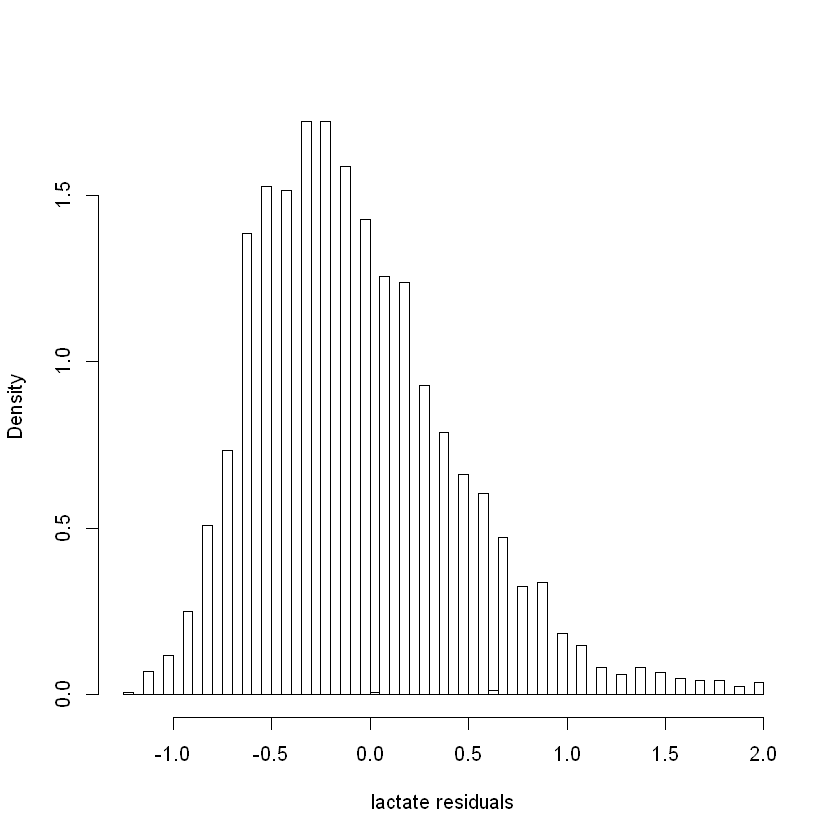

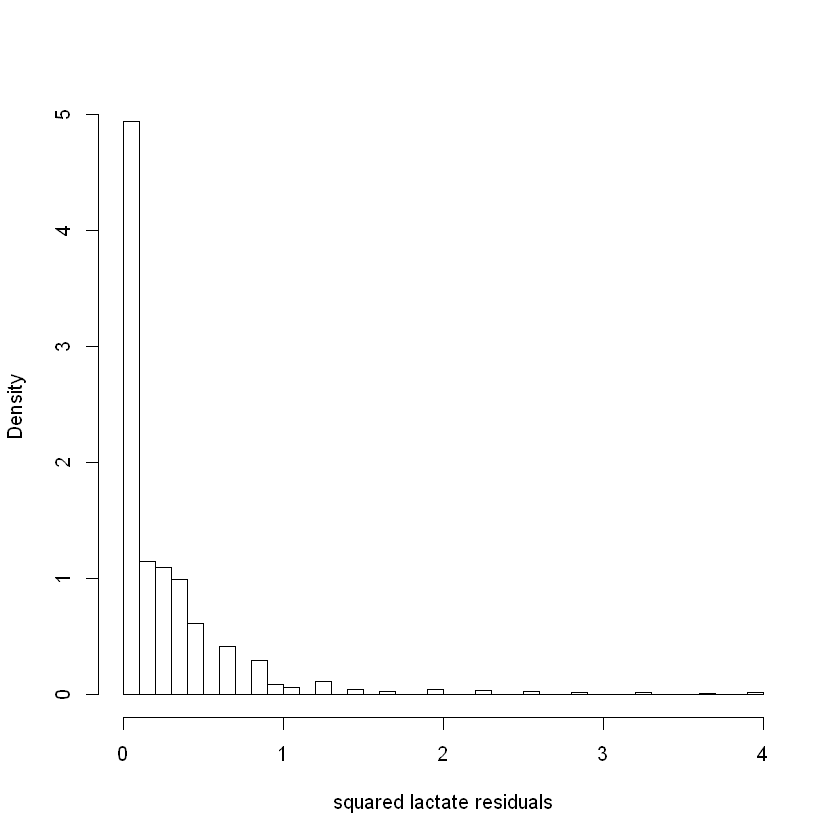

In [4]:
lactate.residuals <- df$lactate_min - mean(df$lactate_min)
lactate.residuals.sq <- lactate.residuals^2
# subsetting below just to make plots look nicer; technically not kosher
hist(lactate.residuals[lactate.residuals <= quantile(lactate.residuals, 0.99)],
     breaks = 50, prob = T, xlab = "lactate residuals", main = '')
hist(lactate.residuals.sq[lactate.residuals.sq <= quantile(lactate.residuals.sq, 0.99)],
     breaks = 50, prob = T, xlab = "squared lactate residuals", main = '')

The sample variance is then defined as a sample mean of this particular transformation of the data.  Let $n$ be the number of samples in the dataset. In some definitions, we optionally multiply by a correction factor of $\frac{n}{n-1}$.  To show you all of this in code:

In [5]:
### sample variance computed manually
# create transformed variable
lactate.residuals <- df$lactate_min - mean(df$lactate_min)
lactate.residuals.sq <- lactate.residuals^2
# sample mean of transformed variable
lactate.var.uncorrected <- mean(lactate.residuals.sq) 
# optional correction term
n <- nrow(df)
lactate.var.corrected <- lactate.var.uncorrected * n/(n-1)
lactate.var.corrected

### sample variance computed by the built-in R function
var(df$lactate_min)

[1] 0.6152049

[1] 0.6152049

The interpretation can be summarized as follows: this is your best guess for how far you'd expect a random datapoint's squared deviation to be from the mean.  Ignoring the correction factor, since the sample variance is a sample mean of a transformed variable (squared deviation), this also means that it inherits the mean function's non-robustness property. 

We will discuss 2 robust alternatives. First, the sample **inter-quartile range (IQR)**, which is defined by the 75th-percentile sample order statistic minus the 25th-percentile sample order statistic:

In [6]:
summary(df$lactate_min)
IQR(df$lactate_min)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.100   0.900   1.200   1.301   1.600  23.400 

[1] 0.7

From its definition, this is the length of an interval that captures the middle 50% of the data in terms of percentiles.  The other robust alternative is the sample MAD (median absolute deviation from the median), which can be calculated like

In [7]:
mad(df$lactate_min, constant = 1)

[1] 0.3

Note that the optional argument is required here, since the default constant that the MAD is multiplied by is not 1.  The MAD has a nice interpretation as the "typical" distance you'd expect to find a random data point away from the median; typical in the sense that 50% of deviations are more and 50% are less than this value.

Fun fact: in data that is "symmetric" around the median, the sample IQR should be about 2 times the sample MAD.  

#### At-Home Exercise 1: Practice on Computing Statistics
Compute the sample MAD manually and verify you get the same answer as above.  The computations you need to perform are described explicitly in its full name.

**Solution**:

In [8]:
# step-by-step solution
lactate.median <- median(df$lactate_min)
lactate.residuals <- df$lactate_min - lactate.median
lactate.abs.residuals <- abs(lactate.residuals)
lactate.mad <- median(lactate.abs.residuals)
lactate.mad

# compact solution
lactate.mad <- median(abs(df$lactate_min - median(df$lactate_min)))

[1] 0.3

### Measures of Asymmetry

Asymmetry describes if values tend to deviate more greatly on one side of the mean vs the other.  We will only examine a single statistic, sample **skewness**, and not consider robust alternatives.  Usually, exact quantification of asymmetry is not necessary, so robustness is not quite as important here.  Base R does not have a skewness function, so go ahead and install the "moments" package (uncomment the first line), load it, and then call the skewness function on your data.

In [9]:
#install.packages("moments")
library(moments)
skewness(df$lactate_min)

[1] 9.401909

As we saw last class, it can also be quite fruitful to visualize the degree of sample skewness with a histogram.  Symmetrical data is data with a skewness of 0.  As we saw, medical lab values are often very far skewed right, and making the data "more" symmetrical through a transformation (such as the log) can  make your analysis more interpretable, accurate, and/or numerically stable in some cases.

However, you should be careful about translating interpretations of a transformation back to the original scale.  For example, if you take a mean on the log-scale and convert back to the original scale, this is not equal to the mean on the original scale:

In [10]:
mean(df$wbcc_max) # sample mean in original-scale

log.wbcc.mean <- mean(log(df$wbcc_max)) # sample mean in log-scale
exp(log.wbcc.mean) # convert log-scale mean back to original-scale

[1] 16.64285

[1] 13.42408

### Standardization

A **standardization** is a transformation of the data such that the transformed variable has "standardized" measures of location and scale.  The most common type of standardization is a z-score transformation, leaves us with a sample mean 0 and sample standard deviation 1 transformed variable.  This is accomplished by first subtracting the sample mean followed by dividing by the sample standard deviation.  To see this in action:

In [11]:
bicarb.z.score <- (df$bicarbonate_max - mean(df$bicarbonate_max))/sd(df$bicarbonate_max)
mean(bicarb.z.score) # e-16 means times 10^(-16), so a ridiculously small number; very small numerical error
sd(bicarb.z.score)

[1] 1.059685e-16

[1] 1

Z-score standardization is useful for a variety of reasons.  One of them is that we can interpret the transformed values as "number of standard deviations away from the mean". Another useful feature is that apart from the location and scale, they leave all other aspects of the *shape* of the data intact, which you can visualize with a histogram.  This can be quite useful to get a feel for the patterns of variation in your data around the mean. 

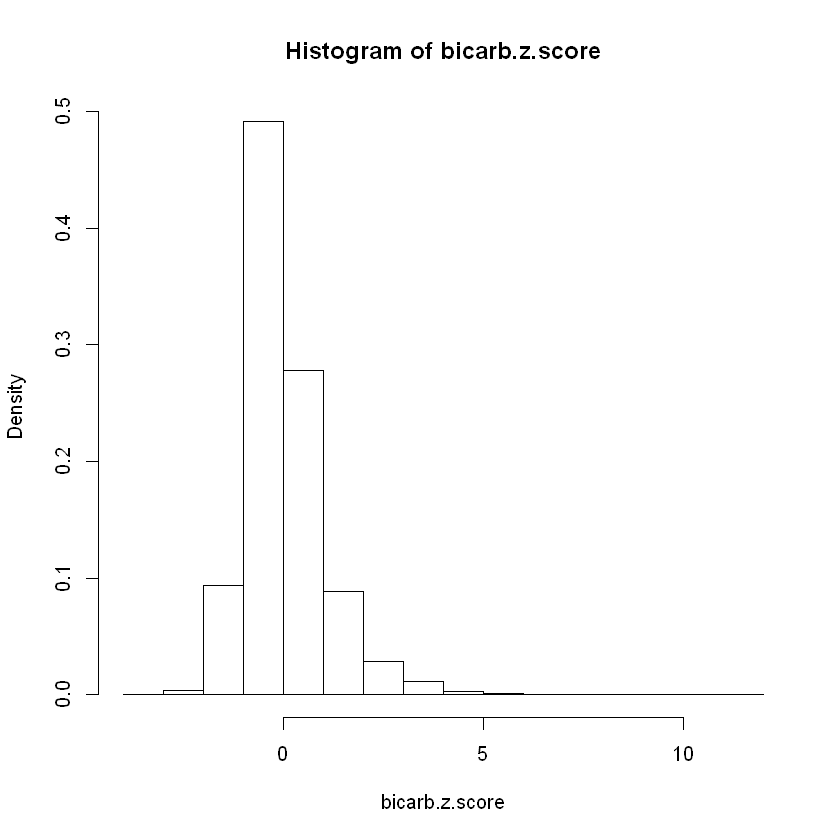

In [12]:
hist(bicarb.z.score, probability = T)

As we can see from this, we can visually identify skew as we could before.  But we can also see that most data is quite concentrated near the mean (indicated by the high peak), with quite large deviations when they do occur (indicated by the right tail having non-neglible height at a distance of 5-6 standard deviations away from the mean).

### Quantile-Quantile Plots

If we want to compare the "shape" of our data to a standard reference "shape", we can use quantile-quantile plots (i.e. Q-Q plots).  We will discuss this idea of "reference shape" more formally today in the section on probability, but in a nutshell, we have established a number of "classical shapes" that data could possibly take.  They are "classical" and very useful because they are idealized and can be described very precisely mathematically.  Real data almost always has a unique shape that doesn't really quite fit into any of these molds exactly, but oftentimes they can come pretty close.  A Q-Q plot is a way of visualizing how close your data is to one of these reference "shapes/molds".

The way a Q-Q plot works is by plotting the true order statistics of the reference "shape" on the x-axis, and plotting the sample order statistics of your actual data on the y-axis.  If the shapes match, then the points should approximately follow a straight line.  Any systematic deviations from this line show you exactly how your data systematically differs from the reference. 

I am sure you all have heard about the normal distribution before and are familiar with its bell-curve-like shape; this is an example of a reference "shape".  Let's visualize if sodium_min is close to following  distribution. Here is the histogram of sodium_min.

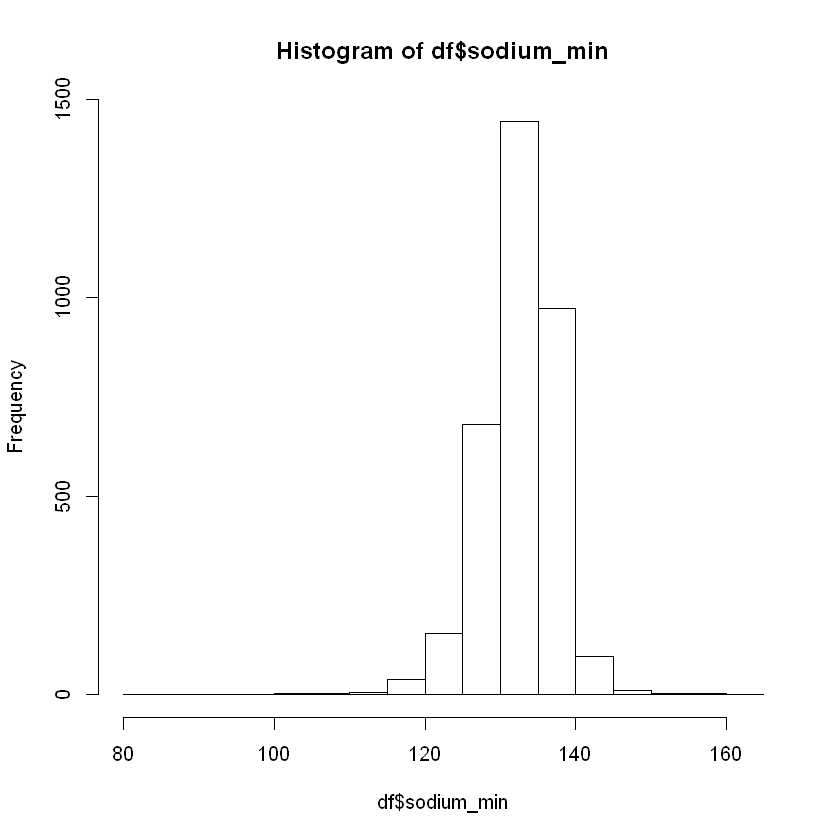

In [13]:
hist(df$sodium_min)

This looks sort-of, approximately bell-shaped?  Can we gain more insight on this? R has a function for creating Q-Q plots using the normal distribution as the reference called **qqnorm**.  We can additionally call the **qqline** function, which automatically draws the appropriate straight line that indicates a match; the additional arguments are for color and line width.

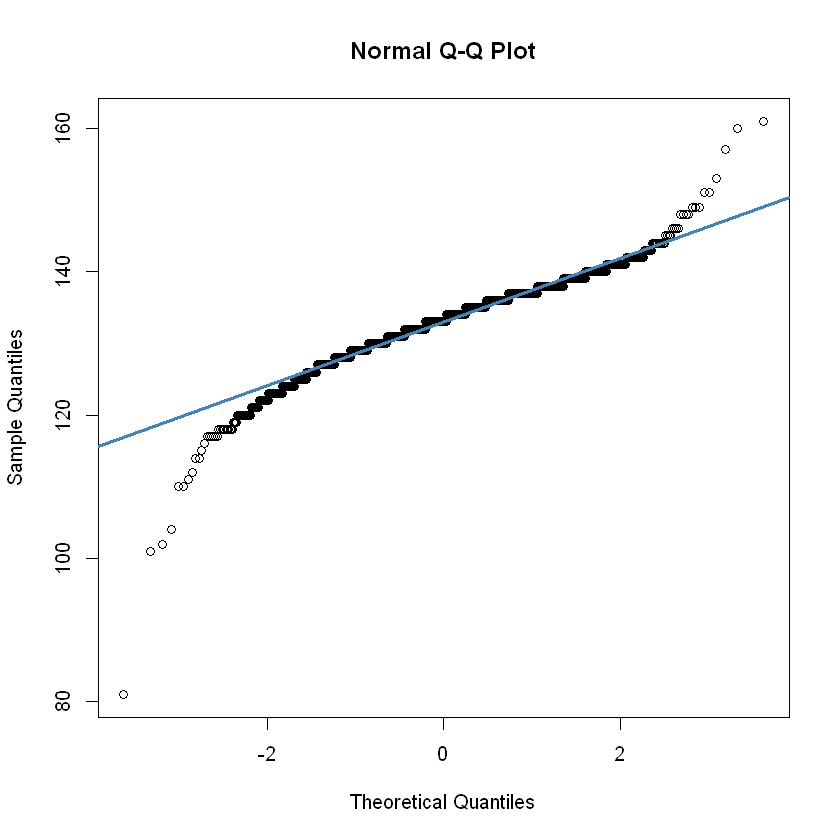

In [14]:
qqnorm(df$sodium_min)
qqline(df$sodium_min, col = "steelblue", lwd = 3)

This is a pretty close match, but it's not perfect.  From this Q-Q plot, we can see that the shape of sodium_min has slightly "fatter tails" indicated by our data having higher values than the reference on the right and lower values than the reference on the left.  This means there's a slightly higher probability of observing extreme values in our data compared to a normal distribution.

You can make a univariate Q-Q plot with respect to any reference distribution, but we will just use the normal distribution as that will be most relevant for our needs.

## Bivariate Analysis
### Discrete-Discrete

To explore the relationships between two discrete variables, we can make use of the **table** function once again to get the counts at the intersections of the categories or levels across the variables.  You can name your arguments 

In [15]:
race.steroid.table <- table('race' = df$race, 'steroid' = (df$steroid == 1))
race.steroid.table

       steroid
race    FALSE TRUE
  Asian    19   47
  Black   320  545
  Other   138  331
  White   614 1402

However, this isn't very interpretable, since each race is present in the dataset in varying proportions.  We can once again make use of the **prop.table** function, but this time we need to indicate what we would like to divide by.  Our choices are the column sums, the row sums, or the total sum.  The default is total sum, the argument "margin = 1" corresponds to row sums, and "margin = 2" corresponds to column sums.  In this case, the most likely scientific question would be: is there a difference in how the different races are given steroids?  We can look at this by dividing by the row sums.

In [16]:
race.steroid.table <- prop.table(race.steroid.table, margin = 1)
race.steroid.table

       steroid
race        FALSE      TRUE
  Asian 0.2878788 0.7121212
  Black 0.3699422 0.6300578
  Other 0.2942431 0.7057569
  White 0.3045635 0.6954365

There seem to be some small differences within each column. Each difference in proportions (within a column) corresponds to a potentially interesting statistic, and there seems to be some small differences.  Just like a dataframe, we can extract this info from the table using the same indexing patterns:

In [8]:
prop.table(table('female' = df$femalesex, 'death' = df$died), margin = 1)

      death
female         0         1
     0 0.7732124 0.2267876
     1 0.8164721 0.1835279

In [17]:
race.steroid.table['Black',2] - race.steroid.table['White',2] 

[1] -0.0653787

However, we don't quite have the statistic machinery yet to tell if these differences are systematic or by chance.

#### $2 \times 2$ Table Summaries
Many discrete-discrete analyses in medicine are between two binary variables.  There are 3 statistics that are often used to detect/interpret changes in proportions between two subgroups.  To make the formulas clearer, we will denote each subgroups' proportion as $p_0$ and $p_1$.

- Risk Difference

$$\text{RD} = p_1 - p_0$$ 
This is exactly what we just did above with steroids and black/white race, and the interpretation is exactly what you'd expect. 

- Relative Risk / Risk Ratio

$$\text{RR} = \frac{p_1}{p_0}$$

This ratio expresses how much more likely you'd expect an event of interest in the top group relative to the bottom group.  A value of 1 indicates events are equally likely between the groups.  A value of 0.5 means the bottom group is $2\times$ as likely to experience the event.  A value of 2.5 means the top group is $2.5\times$ more likely to experience the event of interest. 

- Odds Ratio

Before we get into the ratio, let's first define the odds for group 0.
$$\text{Odds}_0 = \frac{p_0}{1-p_0}$$
This is a quantity that expresses how likely getting the event of interest is compared to not getting the event (within group 0).  A value of 1 indicates that $p_0 = 0.5$.  A value of 2 indicates that $p_0 = 0.666$ and twice as many people get the event compared to those who don't. \
Now, the odds *ratio* is the odds between the two groups:
\begin{align*}
\text{OR} &= \frac{\text{Odds}_1}{\text{Odds}_0} \\
&= \frac{p_1 (1-p_0)}{p_0 (1-p_1)} \\
\end{align*}
As a ratio, this is interpretted similarly to relative risk, but this time describing the differences in the proportions on the *odds* scale.  This may seem more complicated than the risk ratio with little benefit, but this statistic will rear its head again in Session 4. 

#### In-Class Exercise 2: Death-Sex Association
1. Create a $2 \times 2$ table displaying the observed proportions of deaths within males and within females.  Make sure to choose your margin to help explore the scientific question of if there is a difference in death rates between males and females.  Recall that sex is named "femalesex" and death is named "died" in this dataset and both are coded as 0/1.
2. Index the appropriate statistics from this table and assign them to variables "p1" and "p0" with Group 1 being females and Group 0 males.  As an alternative to indexing the table, you could also use the mean function on the original death vector (with appropriate logical indexing) to get these numbers.
3. Calculate and display the risk difference, relative risk, and odds ratio.

**Solution**:

In [18]:
sex.death.table <- table("Death" = (df$died==1), "Female" = (df$femalesex==1))
sex.death.table <- prop.table(sex.death.table, margin = 2)
sex.death.table

       Female
Death       FALSE      TRUE
  FALSE 0.7732124 0.8164721
  TRUE  0.2267876 0.1835279

In [19]:
p0 <- sex.death.table[2,1]
p1 <- sex.death.table[2,2]

rd <- p1 - p0
rr <- p1/p0
o0 <- p0/(1-p0)
o1 <- p1/(1-p1)
or <- o1/o0

print(c("Risk Diff" = rd, "Risk Ratio" = rr, "Odds Ratio" = or))

  Risk Diff  Risk Ratio  Odds Ratio 
-0.04325973  0.80925002  0.76637294 


To close out this section, we'll show you how to create a bar plot using the **barplot** function.  You can simply pass in a vector of values, and R will know how to construct it.  If you pass in a table, R will create a stacked/grouped barchart with the grouping variable being the columns (margin = 2).  You can use the **t** function on the table to switch the rows and columns; this allows you to switch the grouping variable for the grouped bar chart.

There are several useful arguments. I will used the "ylim" argument to make sure the y-axis spans the interval $[0,1]$ for clarity in interpretation.  The "beside" argument indicates if the bars should be side-by-side or stacked.  Lastly, we use "legend.text" to display the legend for the variables that is *not* represented on the $x$-axis.  This time, we'll look at the relationship between race and discharge disposition.

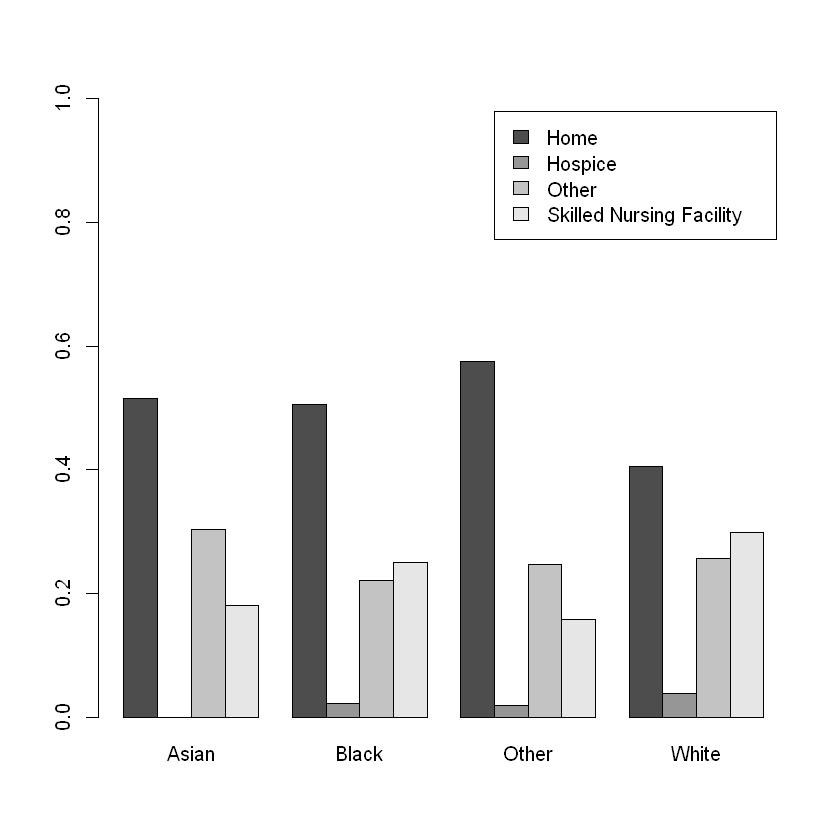

In [20]:
race.discharge.table <- table('race' = df$race, 'discharge' = df$discharge_dispsn)
race.discharge.table <- prop.table(race.discharge.table, margin = 1)
barplot(t(race.discharge.table), 
        ylim = c(0,1),
        beside = T,
        legend.text = T)

### Discrete-Continuous

When exploring the relationship between a discrete and continuous variable, you can reframe it as a subgroup analysis of the continuous variable, subsetting to each category or level of the discrete variable.  This means you are effectively just performing two (or more) univariate analyses and comparing the results.  Comparing the results usually amounts to simply taking the mathematical difference of the summary statistic between the two groups.

#### In-Class Exercise 3: Fill in Table 1

Below is an empty "Table 1", which is often the first table presented in a medical study, comparing the characteristics of 2 groups of interest.  Compute the necessary information to fill out this table.

Let $n$ represents the number of patients. The median (IQR) format is used for continuous variables.  The count (percent) format is used for binary variables.  The names of the relevant variables are "died", "femalesex", and "age".

Note: there is more than one way to get the needed statistics for "femalesex"; the technique we talked about in the discrete-discrete section is one of them, but a subset then summarize approach would work as well.


|       | Death | No Death |
| ---------------------- | ---------------------- | ---------------------- |
| n     |        |                 |
| Count Female Sex (%)   |         |        |
| Median Age (IQR)      |        |          |

Simply compute the needed statistics and record them in a comment; you are not being asked to programatically construct a table.

**Solution:**

In [21]:
select <- df$died == 1

# n
n.died <- sum(select)
n.alive <- length(select) - n.died

# female 
# im using the table method from the previous section
fem.table <- table('female' = df$femalesex, 'death' = df$died)
n.fem.died <- fem.table[2,2]
n.fem.alive <- fem.table[2,1]
fem.prop.table <- prop.table(fem.table, margin = 2)
perc.fem.died <- fem.prop.table[2,2]
perc.fem.alive <- fem.prop.table[2,1]

# age
med.age.died <- median(df$age[select])
med.age.alive <- median(df$age[!select])
iqr.age.died <- IQR(df$age[select])
iqr.age.alive <- IQR(df$age[!select])

# display result
# you don't need to understand the code below
M <- c(n.died, n.alive, n.fem.died, n.fem.alive, med.age.died, med.age.alive)
perc.fem.display <- paste0(round(100*c(perc.fem.died, perc.fem.alive),2), '%')
M[3:6] <- paste0(M[3:6], 
                 ' (',
                 c(perc.fem.display, iqr.age.died, iqr.age.alive),
                 ')')
M <- matrix(M, byrow = T, ncol = 2)
rownames(M) <-  c('n', 'Count Female Sex (%)', 'Median Age (IQR)')
colnames(M) <- c('Death', 'No Death')
M

,Death,No Death
n,708,2708
Count Female Sex (%),283 (39.97%),1259 (46.49%)
Median Age (IQR),73 (20),66 (23)


#### Boxplots
There are plenty of other statistics we can use for comparison such as measures of scale or asymmetry.  Ratios are also a possible alternative to differences when we're primarily interested in location.  To get a general sense of the differences in location, scale, asymmetry, and just overall shape in your data between multiple groups, you can use a box-and-whisker plot visualization.  The box consists of 3 sample order statistics: the 25th percentile, the median, and the 75th percentile. By defulat in R, the whiskers extend to the farthest data point that is less than $1.5 * \text{IQR}$ away from the edges of the box. However, note that other definitions exist for how far the whiskers should extend. Any data outside of the bounds of the whiskers is displayed point-by-point by asteriks, but you can turn these off with the "outline = F" argument.  Turning this off is recommended for highly skewed data.  Let's examine the association we brought up during exercise 2 using the **boxplot** function; this function makes use of the formula/data pattern:

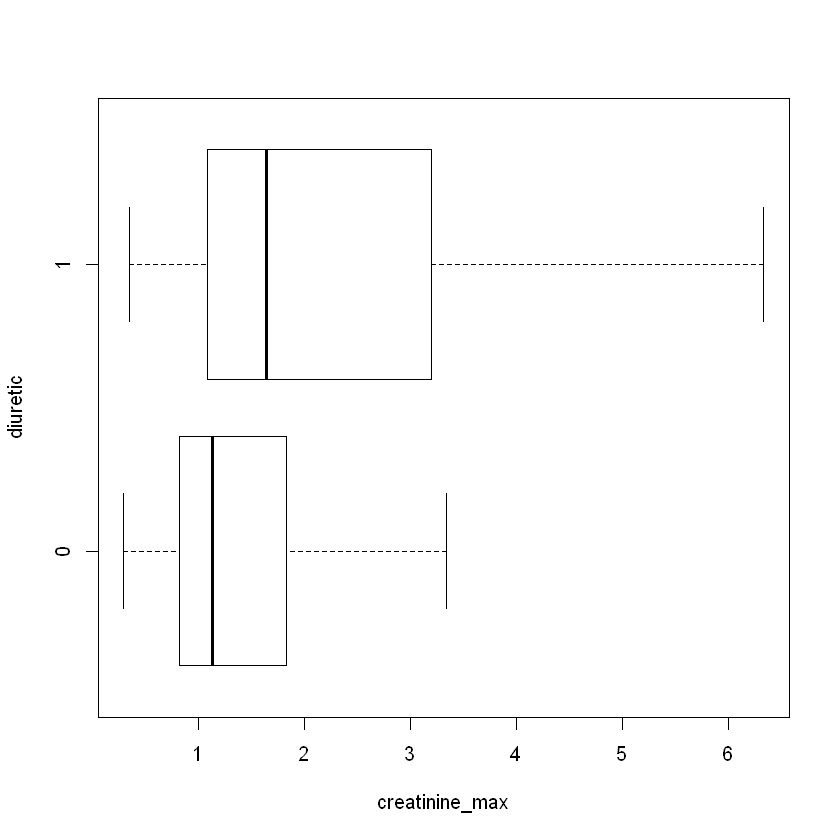

In [10]:
boxplot(formula = creatinine_max ~ race, data = df, outline = F, horizontal = T)

This gives us a more complete sense of the differences between these two groups when it comes to maximum creatinine than any single summary statistic by itself.

#### In-Class Exercise 4: Creatinine-Race Association
Construct a boxplot to compare the shape of creatinine_max data between patients of different races.  Use the formula pattern as shown above and recall that the race variable is called "race".  Look at the plot with and without outliers.  Which is more useful? Comment on your general findings.  

**Solution:**

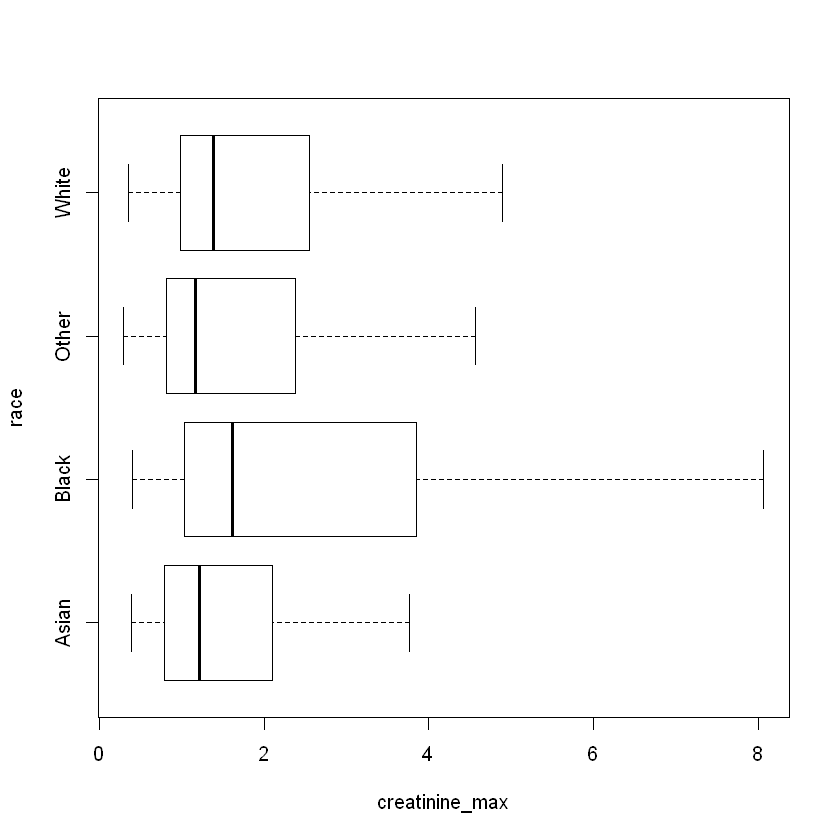

In [23]:
boxplot(formula = creatinine_max ~ race, data = df, outline = F, horizontal = T)

Including the outlier makes the plot way less useful.  Black people tend to have larger creatinine values overall.  There is some evidence that black people have slightly higher muscle mass, which might be able to causally explain some of this association.  However, complicated historic, socioeconomic, and cultural forces dictate who is in our dataset, their health status, how they are treated in the hospital, etc... which in turn affects our observed association.  Without lots of very specific data, assumptions, and methodology, it is impossible to disentangle these effects.  In light of this, you should never assign causality to what you see (except in very specific circumstances), and always default to the weaker claim of association.

#### Q-Q Plots Revisted

You can use the **qqplot** function to compare the shapes of two subsets of a continuous variable in your data, without referencing some theoretical shape.  It is not straightforward to create the straight line in this context, so we will ignore it and try to eyeball the plot.  

A medication may produce a shift in the location and/or scale of a laboratory variable without affecting the overall shape.  Here we can see an example with a significant shift in the median, but the scale and shape features remain the same across the medication and no-medication groups.  To make highly skewed plots more interpretable, we may manually specify the range of the $x$ and $y$ axes as vectors specifying the boundaries.  We make use of the quantile function to only include data between the 1st and 99th percentiles of the data in the visualization. 

[1] -30

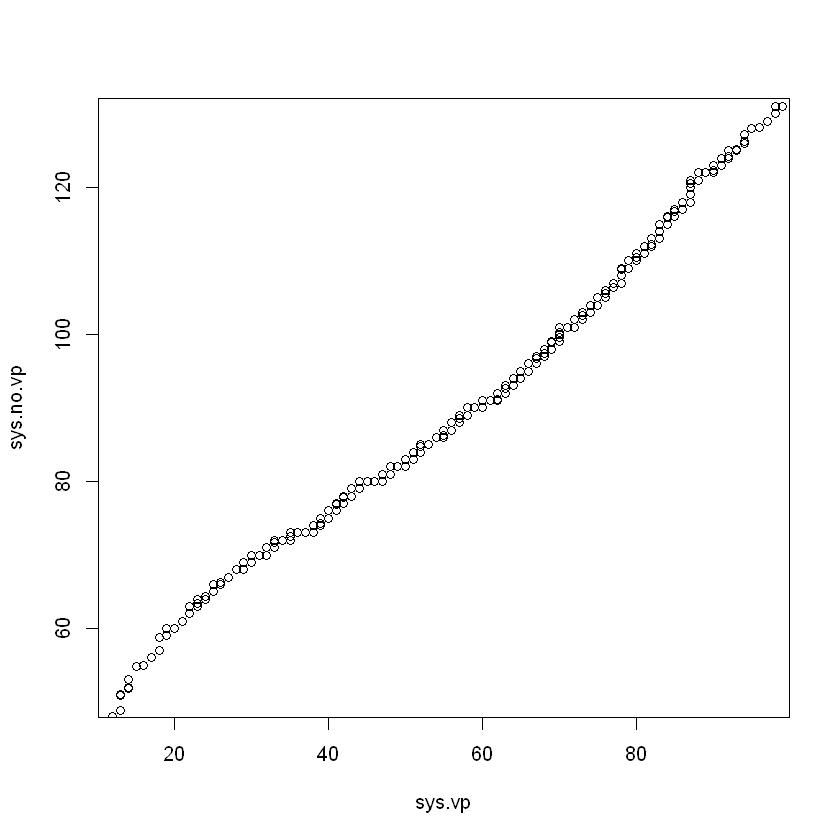

In [24]:
# create subgroups
select.vp <- df$vasopressor == 1
sys.vp <- df$systolic_min[select.vp]
sys.no.vp <- df$systolic_min[!select.vp]

# compare subgroups
median(sys.vp) - median(sys.no.vp)
qqplot(sys.vp, sys.no.vp, 
       xlim = quantile(sys.vp, c(0.01, 0.99)),
       ylim = quantile(sys.no.vp, c(0.01, 0.99)))

On the other hand, shapes oftentimes end up being very different in subgroups.

[1] 3.17

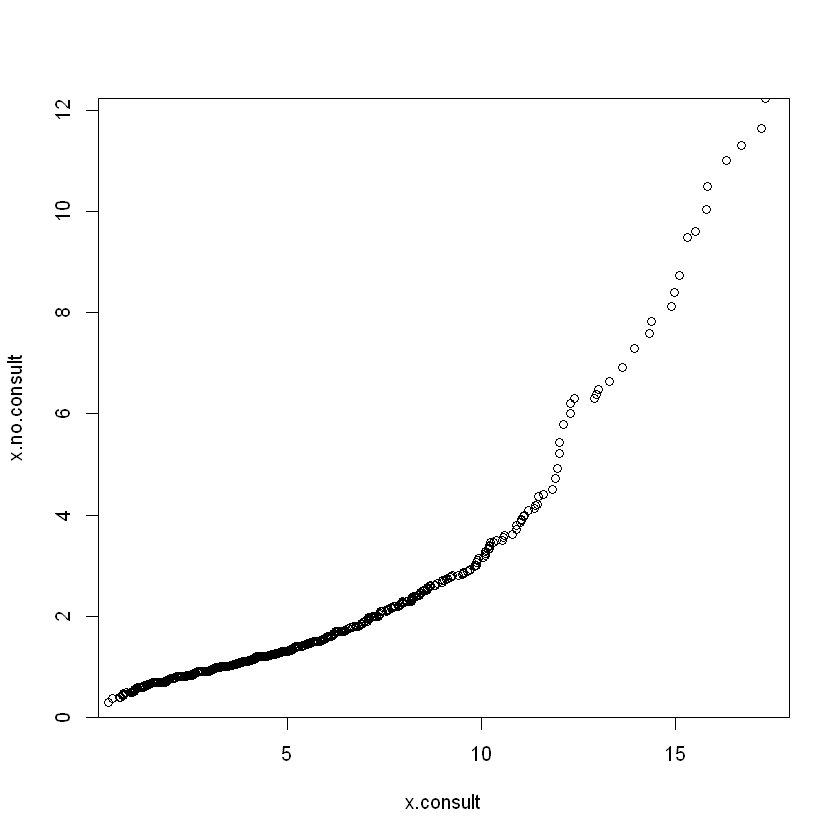

In [25]:
# create subgroups
x <- df$creatinine_max
select.consult <- df$consult_nephrology == 1
x.consult <- x[select.consult]
x.no.consult <- x[!select.consult]

# compare subgroups
median(x.consult) - median(x.no.consult)
qqplot(x.consult, x.no.consult, 
       xlim = quantile(x.consult, c(0.01, 0.99)),
       ylim = quantile(x.no.consult, c(0.01, 0.99)))

This type of plot will provide an appropriate tool to use in conjuction with a particular hypothesis test in Session 3.  

### Continuous-Continuous
Lastly, we may be interested in if two continuous variables are associated with each other in any way.  To get a sense for the relationship, first we visualize using a scatterplot.  Let's look at two variables we apriori believe to be strongly correlated:

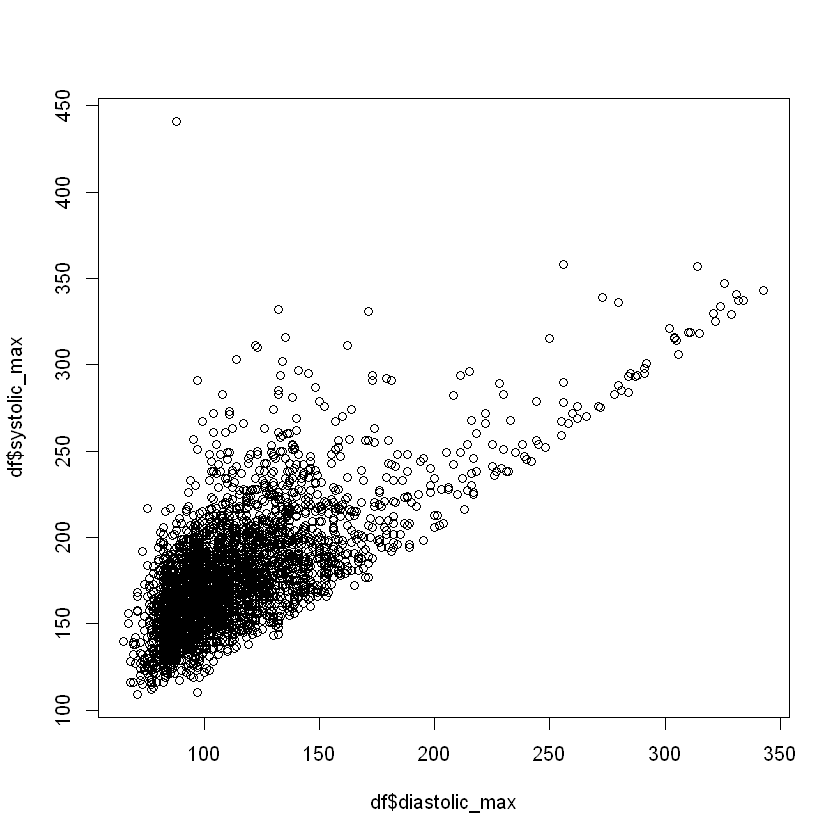

In [26]:
plot(df$diastolic_max, df$systolic_max)

Scatterplots are nice for sanity checks.  There is some strange structure here; many patients have max systolic bps that are near equal to their max diastolic bps.  The boundary makes sense that systolic can never drop below diastolic, but a gap so small is also suspect.  Medical data is ripe with errors, and this suggests that one may have been made upstream in how the data was collected.  At least, it should be investigated.  Regardless, we shall procede as if it were correct.

To quantify the association we can use either the **Pearson correlation** or **Spearman correlation** statistics.  This Pearson correlation statistic essentially measures how *linearly* related two continuous variables are, i.e. how "close" the data is to some straight line.  Furthermore, it is bounded between -1 and 1.  These boundaries are only achieved if the two variables make a perfectly straight line on a plot, i.e. the variables are perfectly predictive of eachother and linear.

R provides a handy function to compute this correlation statistic.

In [27]:
cor(df$diastolic_max, df$systolic_max)

[1] 0.7078407

The Spearman correlation statistic measures something very similar.  It measures how *monotonically* related two continuous variables are.  Monotonic means that the variables are either increasing together or decreasing together as you move right on the scatter plot.  This means the spearman correlation statistic can capture more shapes than just linear; it is a *robust* correlation statistic in that it is not dependent on the scale or skew of your variables.  This statistic is also bounded between -1 and 1.  To compute it, we use the same function, but provide the argument "

In [28]:
cor(df$diastolic_max, df$systolic_max, method = 'spearman')

[1] 0.6299806

Now let's look at 2 variables we might not expect to have an association.

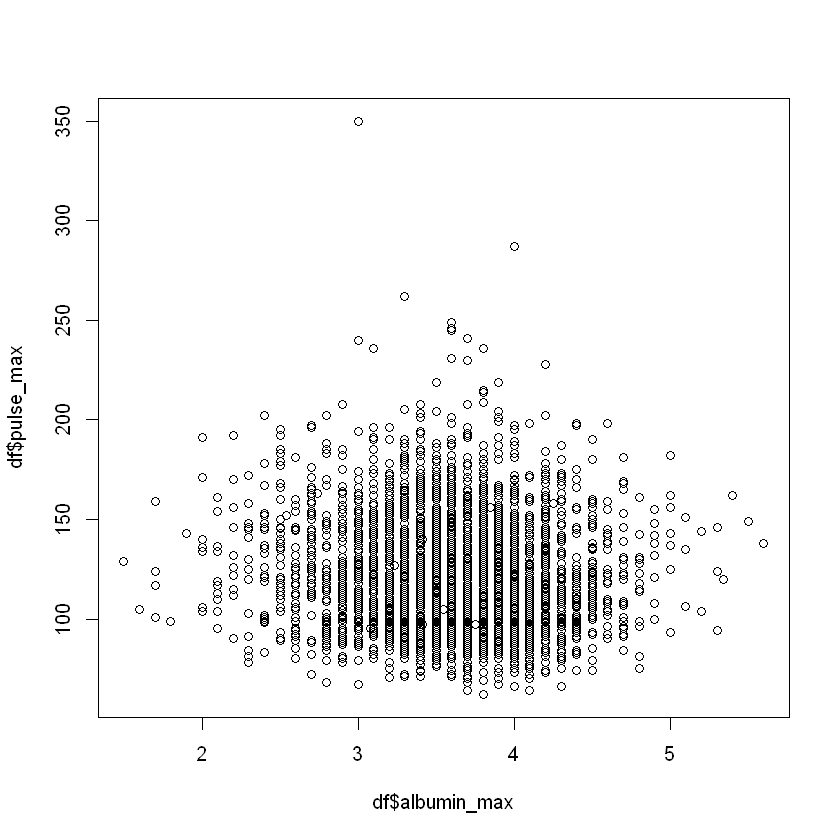

In [29]:
plot(df$albumin_max, df$pulse_max)

In [30]:
cor(df$albumin_max, df$pulse_max)
cor(df$albumin_max, df$pulse_max, method = 'spearman')

[1] -0.06270005

[1] -0.0586558

The correlations are nearly 0.  In the scatterplot, the clustering of the points into these vertical stripes additionally reveals that albumin_max has been discretized at the 0.1 level.  Discretization of continuous variables always takes place to some extent and as long as its sufficiently fine-grained (at a small enough level), we still treat the variable as continuous.  Laboratory values are frequently discretized at the 0.1 or 0.01 levels.

#### In-Class Exercise 5: Creatinine-BNP Association
Plot the scatter plot for creatinine_max and bnp_max and then compute each correlation statistic.  Do you notice anything weird in the plot?  Why do you think your correlation statistics are different?

[1] 0.3887318

[1] 0.5494891

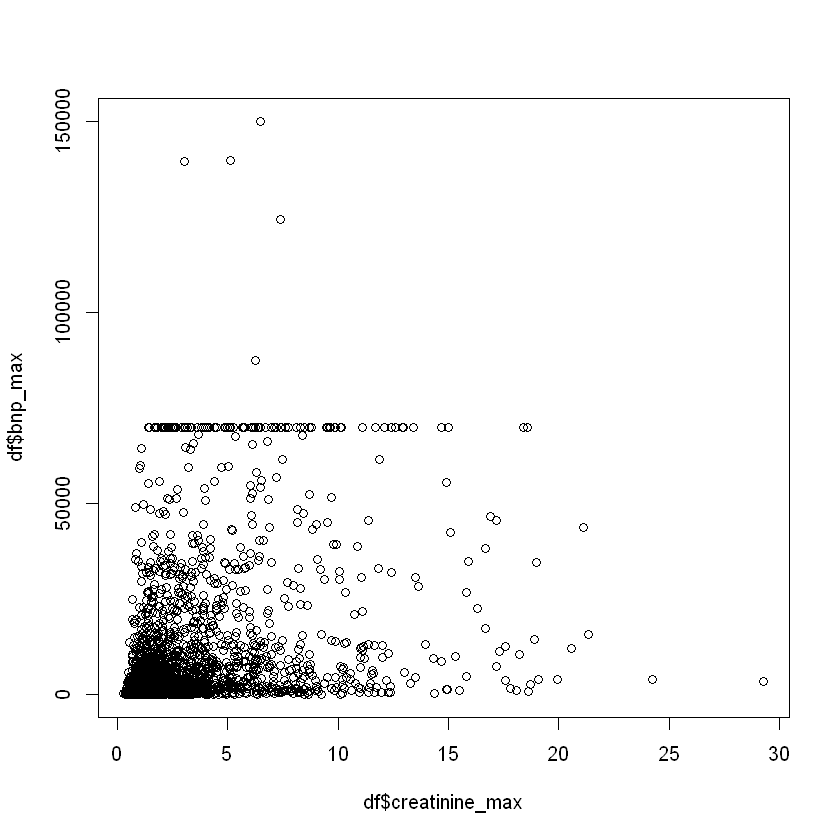

In [31]:
plot(df$creatinine_max, df$bnp_max)
cor(df$creatinine_max, df$bnp_max)
cor(df$creatinine_max, df$bnp_max, method = 'spearman')

The instruments used to measure bnp clearly have an upper bound, which can be seen in the plot.  The difference in the correlation statistics can be attributed to two things:
- the scale of bnp being so large makes Pearson's correlation highly subject to the extreme values
- the relationship may not be perfectly linear - perhaps it is something closer to exponential, which is monotonic and thus better detectable by Spearman's correlation

# From Descriptive to Inferential Statistics

## Probability

### Randomness
Descriptive statistics are nice, but because statistics are fundamentally *random* (since the sample selection process is random), it is difficult to answer some scientific questions in a definitive way. E.g.) Are these two sample means from different subgroups actually fundamentally distinct?  Or did the randomness of the sample just make them appear different by chance?  In order to answer these questions, we need to be able to study, formalize, and quantify randomness.

But first! - a quick philosophical aside.  What does it mean for something to be random?  Randomness comes in 2 flavors - *aleatoric* and *epistemic*. Epistemic randomness is "apparent" randomness in that phenomena simply appear random to us because we don't have enough information. We don't understand the exact structure of what we're studying and/or we couldn't measure many of the relevant variables, since it's expensive and intrusive. Aleatoric randomness describes something "intrinsically" random, like you might see in many interpretations of quantum mechanics. It can also describe the randomness amounting from the millions of tiny effects that one could and would not even practically measure.

I think epistemic randomness is a lot more useful of a perspective to hold in most statistical science.  If we had a multi-organ simulator for a patient and could measure every relevant variable, whether a patient will have heart failure within a year could be almost fully determined.  But we don't have any of this information.  We can make best guesses from the small amount of things we know -  age, sex, race, the average rate of heart failure, etc... but their personal likelihood for heart failure will still be mostly unknowable to us.  We call this uncertainty derived from lack of knowledge as randomness.

### Models
To formalize randomness, we must create a *probability model*.  This essentially amounts to choosing certain variables to treat as random (such as an outcome of interest) and then describing a random way that data was *generated* (e.g. a weighted-coin flipping model for a binary outcome) in a large population of patients.  To describe how the data was generated, it is equivalent to either partially or completely specify the "shape" of what a large amount of generated data would look like (same idea behind the histograms we looked at earlier but with infinite data).  This "shape" is known as a *probability distribution*. 

We will start with some cases where we completely specify the distribution.  Most of the classical distributions have *family* names and *parameters* that distinguish between distributions within that family.  Typically the family specifies an overall shape, and the parameters pin down exact values for the true mean/variance/skew of the distribution.  As an analogy, you can think about actual geometric shapes.  Rectangles and circles are each a "family" of shapes.  The shape itself can be exactly identified by specifying the parameters height and width, or radius, respectively.

### The Normal Family
Arguably, the most important family in all of statistics is the *Normal* family. The distribution within the family can be specified with two parameters, the true/population mean and true/population standard deviation.  Recall that for unimodal distributions, we claimed that at least 89% and 95% of the data would be within 2 and 3 standard deviations from the mean, respectively.  For the Normal family, we can strengthen this claim.  Nearly exactly 68%, 95%, and 99.7% of the data is within 1, 2, and 3 standard deviations from the mean, respectively.

R provides us with the *rnorm* function for generating *samples* from any Normal distribution.  Let's specify a normal probability model with mean 100 and standard deviation 15 for IQ scores and generate a lot of samples, so we can visualize its shape. 

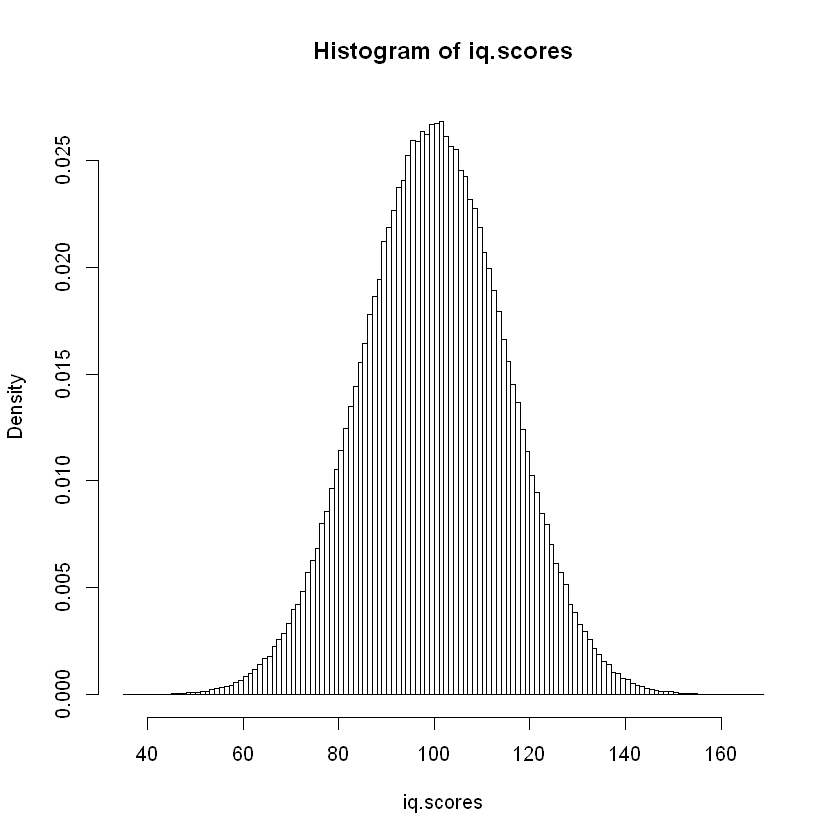

In [32]:
iq.scores <- rnorm(500000, mean = 100, sd = 15)
hist(iq.scores, probability = T, breaks = 100)

Recall, when "probability = T" in the histogram, you can interpret the height times width of a bin as the probability of a sample being in that bin.  In turn, you can also interpret that as the probability a newly generated sample would be in that bin.  A more qualitative observation is that more height in the histogram naturally corresponds to more "density" in generating samples locally to those values.  

The goal of statistics is to connect some data we actually observe with some theoretical and idealized probability model.  We've specified our theoretical probability model. So lets generate some new data, but I won't tell you how I generated it.  This is how data actually comes to you in the real world; nature knows the distribution and generates the data, but you don't ever get to know what the true distribution is.  Pretend this data corresponds to IQ scores of a random selection of 40 graduating high school students who took 2+ AP courses in their final year.

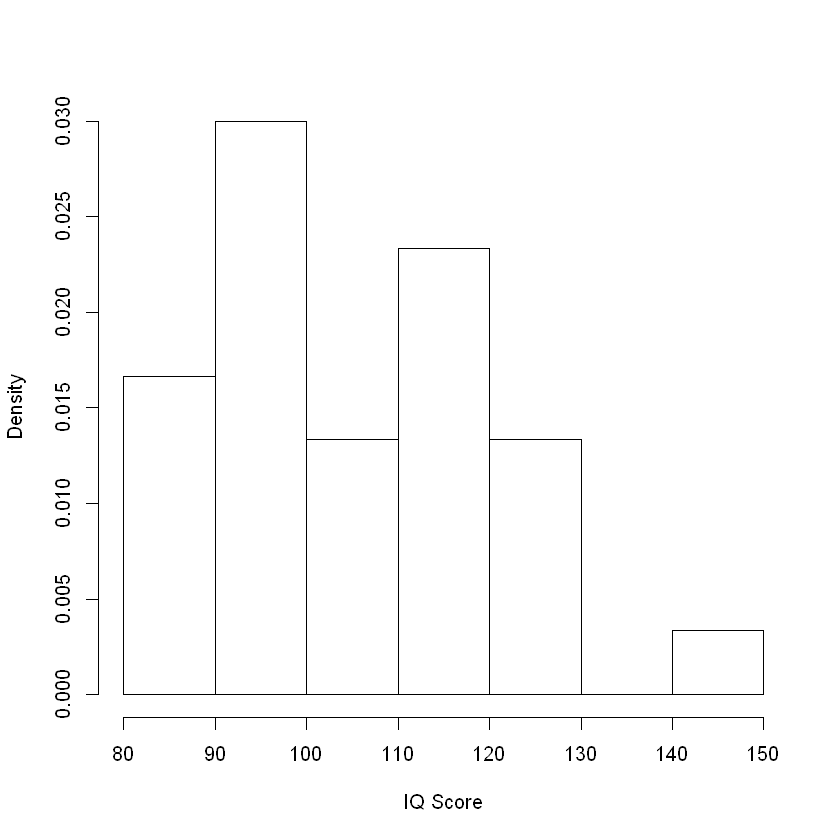

In [33]:
set.seed(12792) # ignore; here for reproducibility
iq.sample <- rnorm(40, mean = 108, sd = 15)
hist(iq.sample, probability = T, xlab = 'IQ Score', main = '')

Now, we can ask particular scientific questions and mathematically tie them to answers about the probability model that generated our data.  Let's start with the vague question of - is taking 2+ AP courses associated with a higher IQ?

We must make some simplifying assumptions to model things in the world.  We apriori know that IQ scores of the public follows a normal distribution with mean 100 and standard deviation 15.  So it is reasonable to assume that IQ scores in this specific group may follow a distribution that is quite similar.  To make modeling tractable, we may first assume our particular sample was *also* generated from a distribution in the Normal family like the public's.  For simplicity, we may further assume that the variability of this distribution is the same as the public's. In summary, we assume our sample was generated from some Normal distribution with a standard deviation of 15.  

The only free variable left in pinning down the distribution is the mean.  Now, we can ask a specific mathematical question.  Given our sample data comes from some Normal distribution with standard deviation 15, is this distribution's true mean the same as the true mean of the public (100)?  Or does taking AP courses correlate with having slightly higher IQ scores (and thus a higher mean) overall?  We will develop statistical machinery in the next session that gives a probabilistic answer to this question.  In turn, the answer to this mathematical question will also answer the scientific question about whether our association is real.  This is what is meant by *inferential* statistics.  

A short recap - the goal of statistics is to connect the data we observe to some theoretical and idealized probability model.  Our use of this probability models (along with some simplifying assumptions) allow us to derive mathematically precise conclusions, which in turn correspond to scientific conclusions.  

You may be questioning the validity of this methodology.  How do we know the assumptions we make are true?  Does anything in the real world actually correspond to some idealized probability model?  You don't always and no.  But to quote George Box - "All models are wrong, but some are useful."  The idea is that you should try to model things in a way that's "close enough" to reality.  If you are successful, the accuracy of your results are also "close enough".

## Simulation

As we saw with the Normal distribution, simulating in R is extremely easy and is one of its greatest strengths.  Pick a common family and R has a built-in function to **sample** from any distribution within that family.  A sample is a single random draw in accordance with the probabilities of a distribution.  For example in a fair coin toss, I would sample a *heads* with 50% probability and a *tails* with 50% probability.  If you took a very large number of samples from a continuous distribution (like one governing IQ scores), their histogram should look exceedingly similar to the distribution you sampled from.

In R, you can sample by 
- using functions that start with "r" and are followed by the family name of the distribution (or some short form of it)
- specifying the number of samples you want as the first unnamed argument.
- specifying the parameters of the distribution in the family using named arguments afterwards.  Use the help tool to see what these parameters are called. 

We already saw the Normal family in action earlier.  Next, we will explore a family of distributions for binary outcomes.

### The Bernoulli Family
You should think about a Bernoulli distribution as a weighted coin.  A sample from the distribution corresponds to a flip of the coin.  1 corresponds with heads and 0 corresponds with tails.  To explain the function name in R, I'll simply mention that the Bernoulli family is a subfamily of the Binomial family, just as squares are a subfamily of rectangles.  We use the argument "size = 1" to specify that we want the Bernoulli family.  A Bernoulli distribution is specified by a single parameter that describes the probability of heads.  The argument for this is "prob".  Hence, generating 30 samples from a fair coin model looks like

In [12]:
print(rbinom(30, size = 1, prob = 0.5))

 [1] 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0


### In-Class Exercise 6: Simulating AKI

We have apriori observed the proportion of patients who develop acute kidney injury (AKI) in the hospital is around 14%.  Thus, a reasonable probability model for the binary outcome of AKI would be a Bernoulli distribution with parameter $0.14$.  

1. From this model, generate a "dataset" (read: vector) of AKI outcomes for 100 patients.
2. Using the mean function, calculate the sample proportion of AKI observed.  Record the results in a comment
3. Repeat this process 10x
4. How many datasets estimated a sample proportion of 0.16 or greater with AKI?
5. How many datasets estimated a sample proportion of 0.20 or greater with AKI?

**Solution:**

In [35]:
mean(rbinom(100, size = 1, prob = 0.14))
# run this 10x

[1] 0.17

### Two Views on a "Sample"

We just did an exercise where we generated 100 samples to create a dataset.  These are many samples on the *patient* level.  However, when we averaged those samples and created a statistic (the sample proportion), we actually created a sample of a different kind.  This statistic is a single sample on the *dataset* level.  We can see that it must have been a sample from some distribution, since we noticed variability of our statistic under different datasets.  Specifically, it is a sample from the distribution governing all possible observed-proportion-of-AKI-occurrences-from-random-groups-of-100-patients-from-yale-hospitals.

In short, there's two things you must work to conceptually separate
- Samples/Distributions of your data (think directly at the patient level; you'll get many, many individual samples)
- Samples/Distributions of your statistics (think at the dataset level; you'll only get one sample statistic)

We typically think of data being given to us at the first level.  However, the mathematical conclusions we need for scientific insight operate on the second level.  Probability models give us the machinery to formalize the first level and carry forward conclusions up to the second level.  

Here is an example of one of mathematical tools we use to do this.  Though we will not get into the details, one of the most powerful results from probability is the **Central Limit Theorem**.  It tells us that when you have a large amount of data, no matter what "shape" the distribution of your data has (patient level), most relevant sample statistics (dataset level) nearly perfectly follow some distribution from the Normal family.  Let's see this in action with the exercise we just looked at. We will look at sample proportions of size 100 (like in the exercise) and then 1000 after.  We will do this for 1 million datasets and examine the histogram.  We highlight in shades of (overlapping) pink the regions that correspond to the earlier exercise.

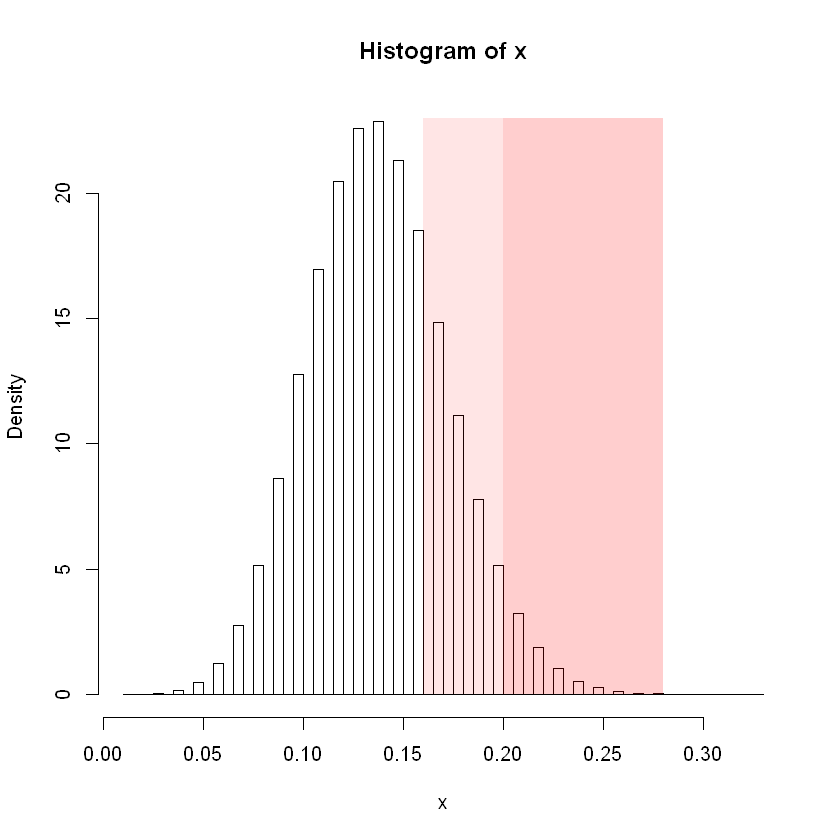

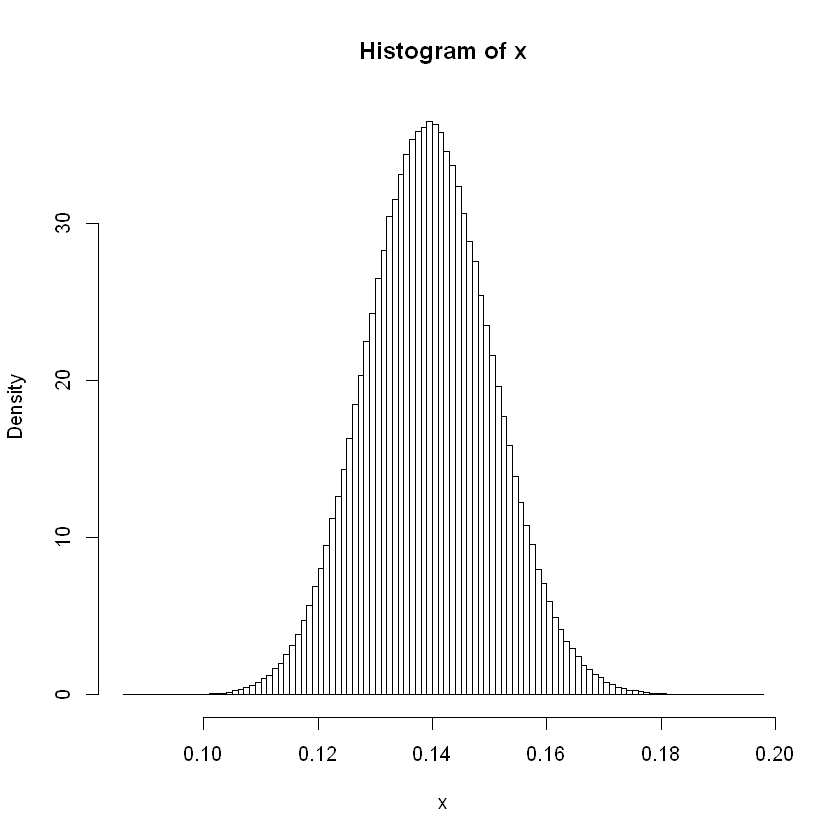

In [36]:
x <- rbinom(1000000, size = 100, p = 0.14)/100
hist(x, prob = T, breaks = 100)

# shading for >= 0.16
polygon(c(0.16, 0.28, 0.28, 0.16), c(0, 0, 23, 23), 
        col = rgb(red = 1, green = 0, blue = 0, alpha = 0.1),
        lty = 0)
# shading for >= 0.2
polygon(c(0.20, 0.28, 0.28, 0.20), c(0, 0, 23, 23), 
        col = rgb(red = 1, green = 0, blue = 0, alpha = 0.1),
        lty = 0)

x <- rbinom(1000000, size = 1000, p = 0.14)/1000
hist(x, prob = T, breaks = 100)

Isn't that remarkable?  We started with discrete 0/1 data on the patient-level.  But we ended with (approximately) Normally distributed data on the statistic-level. 

However, remember that we only get *one* sample from this distribution in real life.  How we interpret the reasonability of that number comes from this theoretical "infinite datasets" experiment we're doing above.  Probability models give us the ability to infer what this theoretical "infinite datasets" distribution might look like, despite only having access to a single sample from it.

 How is this possible? Recall that any Normal distribution can be specified with 2 numbers - the mean and standard deviation.  If we have a probability model at the individual data level, we can use some math to infer what this mean and standard deviation are.  Then we have a (Normal) distribution at the statistics level, and we can interpret where our single sample statistic falls on this distribution.